In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from xgboost import XGBRegressor

In [2]:
driver = 'postgres'
username = 'ds4a'
password = 'ds4A-7eaM79'
host = 'ds4a.cm1dcdf7pnnv.us-east-2.rds.amazonaws.com'
port = 5432
database = 'team_79'

connection_string = f'{driver}://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string, encoding='utf8')

In [361]:
tablas = [
    'violencia_intrafamiliar',
    'homicidios',
    'hurto_automotores',
    'hurto_motocicletas',
    'del_sexuales',
    'hurto_personas'
]

query = '''
SELECT
    FLOOR(row_num/ 2) as week,
    (max(weekly) + interval '14 day')::date as final_sunday,
    sum(total_count) as num_cases
FROM (
    SELECT
        date_trunc('week', fecha) AS weekly,
        row_number() over (order by date_trunc('week', fecha)) - 1 AS row_num,
        COUNT(*)  total_count
    FROM {}
    WHERE fecha >= '2015-12-21'
    AND municipio like 'BOGO%%'
    GROUP BY 1
    ORDER BY 1
) t
GROUP BY 1
ORDER BY 1
''';

In [362]:
data = {i:pd.read_sql(query.format(i), engine) for i in tablas}

In [367]:
def rolling(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def mape(true, preds):
    return np.mean(np.abs(true - preds)/np.abs(true))

In [368]:
def get_data(window_type='W', window_size=5):
    resampled_data = {}
    for i in data.keys():
        data[i].final_sunday = pd.to_datetime(data[i].final_sunday)
        resampled_data[i] = data[i].set_index('final_sunday')['num_cases']
    
    X_train = {}
    X_test = {}

    y_train = {}
    y_test = {}

    for i in tablas:
        X = rolling(resampled_data[i].to_numpy(), window_size)
        y = X[1:,-1]
        X = X[:-1, :]
        
        X_train[i], X_test[i] = X[0:int(X.shape[0]*0.8),:], X[int(X.shape[0]*0.8):,:]
        y_train[i], y_test[i] = y[0:int(y.shape[0]*0.8)], y[int(y.shape[0]*0.8):]

        temp = np.arange(X_train[i].shape[0])
        np.random.seed(0)

        np.random.shuffle(temp)
        X_train[i] = X_train[i][temp, :]
        y_train[i] = y_train[i][temp]
        
    return (X_train, X_test, y_train, y_test, resampled_data)

## XGBoost Models

In [369]:
model = {}
X_train, X_test, y_train, y_test, _ = get_data(window_size=2)
for i in tablas:
    model[i] = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.005, n_jobs=-1)
    model[i].fit(
        X_train[i],
        y_train[i],
        eval_set=[(X_test[i], y_test[i])],
        eval_metric='mae',
        early_stopping_rounds=100,
        verbose=0
    )

In [370]:
for k in range(2, 11):
    model = {}
    X_train, X_test, y_train, y_test, _ = get_data(window_type='W', window_size=k)

    for i in tablas:
        model[i] = XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.005, n_jobs=-1)
        model[i].fit(
            X_train[i],
            y_train[i],
            eval_set=[(X_test[i], y_test[i])],
            eval_metric='mae',
            early_stopping_rounds=100,
            verbose=0
        )

    print('---------------------------------------------------')
    print(k)
    for i in tablas:
        t = '\t'
        if len(i) <= len('hurto_personas'):
            t = '\t\t'
        print(
            i + t, 
            '{:.2f}'.format(skm.mean_absolute_error(y_test[i], model[i].predict(X_test[i]))),
            '  ',
            '{:.2f}'.format(skm.mean_absolute_error(y_test[i], [y_test[i].mean()]*y_test[i].shape[0])),
        )

    print()

    for i in tablas:
        t = '\t'
        if len(i) <= len('hurto_personas'):
            t = '\t\t'
        print(
            i + t, 
            '{:.2f}'.format(skm.mean_squared_error(y_test[i], model[i].predict(X_test[i]))),
            '  ',
            '{:.2f}'.format(skm.mean_squared_error(y_test[i], [y_test[i].mean()]*y_test[i].shape[0])),
        )

    print()

    for i in tablas:
        t = '\t'
        if len(i) <= len('hurto_personas'):
            t = '\t\t'
        print(
            i + t, 
            '{:.2f}'.format(mape(y_test[i], model[i].predict(X_test[i]))),
            '  ',
            '{:.2f}'.format(mape(y_test[i], [y_test[i].mean()]*y_test[i].shape[0])),
        )

    print()
    for i in tablas:
        t = '\t'
        if len(i) <= len('hurto_personas'):
            t = '\t\t'
        print(
            i + t, 
            '{:.2f}'.format(mape(y_test[i], model[i].predict(X_test[i]))),
            '  ',
            '{:.2f}'.format(mape(y_test[i], X_test[i][:, -1])),
        )

---------------------------------------------------
2
violencia_intrafamiliar	 239.13    274.46
homicidios		 7.46    7.66
hurto_automotores	 16.26    19.02
hurto_motocicletas	 25.83    22.35
del_sexuales		 42.53    43.84
hurto_personas		 590.09    476.08

violencia_intrafamiliar	 128890.37    160576.50
homicidios		 111.85    123.42
hurto_automotores	 588.09    913.04
hurto_motocicletas	 1564.46    1359.08
del_sexuales		 4761.18    4659.09
hurto_personas		 1138499.76    802413.17

violencia_intrafamiliar	 1.75    2.16
homicidios		 0.48    0.47
hurto_automotores	 0.50    0.67
hurto_motocicletas	 0.85    0.84
del_sexuales		 2.45    2.24
hurto_personas		 0.26    0.23

violencia_intrafamiliar	 1.75    0.75
homicidios		 0.48    0.74
hurto_automotores	 0.50    0.54
hurto_motocicletas	 0.85    0.78
del_sexuales		 2.45    0.72
hurto_personas		 0.26    0.24
---------------------------------------------------
3
violencia_intrafamiliar	 255.94    274.46
homicidios		 7.45    7.66
hurto_automotores	

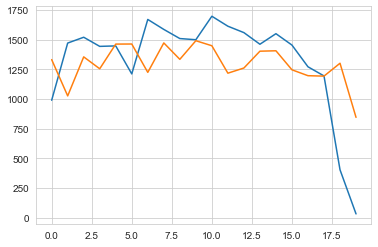

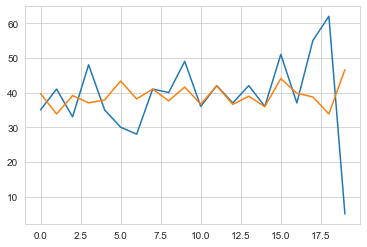

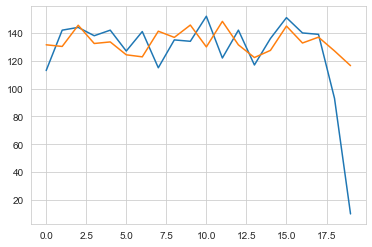

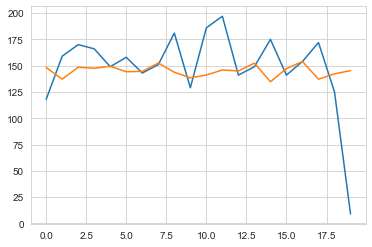

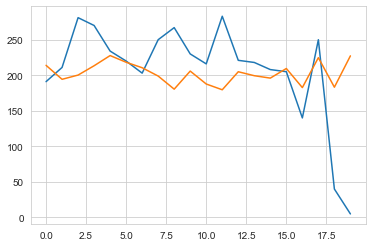

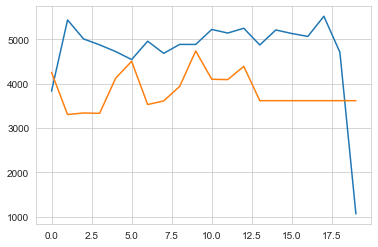

In [371]:
for i in tablas:
    plt.figure()
    x = range(len(y_test[i]))

    plt.plot(x, y_test[i])
    plt.plot(x, model[i].predict(X_test[i]))

## FB prophet

In [332]:
from fbprophet import Prophet

In [378]:
fb_model = {}
fb_train = {}
fb_test = {}

_, _, _, _, resampled_data = get_data()
for i in tablas:
    fb_model[i] = Prophet(weekly_seasonality=True, daily_seasonality=True)
    temp = resampled_data[i].rename_axis('ds').reset_index(name='y')

    fb_train[i], fb_test[i] = temp.iloc[:int(temp.shape[0]*0.8)].copy(), temp.iloc[int(temp.shape[0]*0.8):].copy()
    fb_model[i].fit(fb_train[i])


print('--------------------------------------')
print(k)
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(skm.mean_absolute_error(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
        '  ',
        '{:.2f}'.format(skm.mean_absolute_error(fb_test[i]['y'].to_numpy(), [fb_test[i]['y'].mean()]*fb_test[i]['y'].shape[0])),
    )

print()

for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(skm.mean_squared_error(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
        '  ',
        '{:.2f}'.format(skm.mean_squared_error(fb_test[i]['y'].to_numpy(), [fb_test[i]['y'].mean()]*fb_test[i]['y'].shape[0])),
    )

print()
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
        '  ',
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), [fb_test[i]['y'].mean()]*fb_test[i]['y'].shape[0])),
    )

print()
for i in tablas:
    t = '\t'
    if len(i) <= len('hurto_personas'):
        t = '\t\t'
    print(
        i + t, 
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), fb_model[i].predict(fb_test[i][['ds']]).yhat.to_numpy())),
            '  ',
        '{:.2f}'.format(mape(fb_test[i]['y'].to_numpy(), fb_test[i]['y'][:])),
    )

--------------------------------------
10
violencia_intrafamiliar	 275.56    271.42
homicidios		 8.30    7.59
hurto_automotores	 24.69    18.41
hurto_motocicletas	 25.54    22.62
del_sexuales		 43.31    42.44
hurto_personas		 581.73    466.36

violencia_intrafamiliar	 108628.92    154281.90
homicidios		 126.75    119.79
hurto_automotores	 1020.48    874.98
hurto_motocicletas	 1385.61    1345.51
del_sexuales		 5240.72    4469.51
hurto_personas		 957194.80    775972.27

violencia_intrafamiliar	 1.23    2.06
homicidios		 0.49    0.46
hurto_automotores	 0.62    0.64
hurto_motocicletas	 0.81    0.81
del_sexuales		 2.61    2.15
hurto_personas		 0.25    0.22

violencia_intrafamiliar	 1.23    0.00
homicidios		 0.49    0.00
hurto_automotores	 0.62    0.00
hurto_motocicletas	 0.81    0.00
del_sexuales		 2.61    0.00
hurto_personas		 0.25    0.00
